## 先训练老师网络 

In [26]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torchvision import datasets, transforms
import torch.utils.data


torch.manual_seed(0)
torch.cuda.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [27]:
class TeacherNet(nn.Module):
    def __init__(self):
        super(TeacherNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.3)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        output = self.fc2(x)
        return output


def train_teacher(model, device, train_loader, optimizer, epoch):
    model.train()
    trained_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        trained_samples += len(data)
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, trained_samples, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')


def test_teacher(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)


In [28]:
from torchvision import datasets, transforms


def teacher_main():
    epochs = 10
    batch_size = 64
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=1000, shuffle=True)

    model = TeacherNet().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    
    teacher_history = []

    for epoch in range(1, epochs + 1):
        train_teacher(model, device, train_loader, optimizer, epoch)
        loss, acc = test_teacher(model, device, test_loader)
        
        teacher_history.append((loss, acc))

    torch.save(model.state_dict(), "teacher.pt")
    return model, teacher_history

In [29]:
# 训练教师网络
teacher_model, teacher_history = teacher_main()

E:\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train epoch 1: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0464, accuracy: 9841/10000 (98%)
Train epoch 2: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0379, accuracy: 9871/10000 (99%)
Train epoch 3: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0331, accuracy: 9893/10000 (99%)
Train epoch 4: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0327, accuracy: 9896/10000 (99%)
Train epoch 5: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0341, accuracy: 9900/10000 (99%)
Train epoch 6: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0343, accuracy: 9900/10000 (99%)
Train epoch 7: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0319, accuracy: 9894/10000 (99%)
Train 

##### 看看老师的暗知识 

In [30]:
import numpy as np
from matplotlib import pyplot as plt

def softmax_t(x, t):
    x_exp = np.exp(x / t)
    return x_exp / np.sum(x_exp)

test_loader_bs1 = torch.utils.data.DataLoader(
    datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=1, shuffle=True)

In [1]:
teacher_model.eval()
with torch.no_grad():
    data, target = next(iter(test_loader_bs1))
    data, target = data.to('cuda'), target.to('cuda')
    output = teacher_model(data)

test_x = data.cpu().numpy()
y_out = output.cpu().numpy()
y_out = y_out[0, ::]
print('Output (NO softmax):', y_out)



plt.subplot(3, 1, 1)
plt.imshow(test_x[0, 0, ::])

plt.subplot(3, 1, 2)
plt.bar(list(range(10)), softmax_t(y_out, 1), width=0.3)

plt.subplot(3, 1, 3)
plt.bar(list(range(10)), softmax_t(y_out, 10), width=0.3)
plt.show()

NameError: name 'teacher_model' is not defined

# 让老师教学生网络 

In [32]:
class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = F.relu(self.fc3(x))
        return output

### 关键，定义kd的loss 

In [33]:
def distillation(y, labels, teacher_scores, temp, alpha):
    return nn.KLDivLoss()(F.log_softmax(y / temp, dim=1), F.softmax(teacher_scores / temp, dim=1)) * (
            temp * temp * 2.0 * alpha) + F.cross_entropy(y, labels) * (1. - alpha)


In [34]:
def train_student_kd(model, device, train_loader, optimizer, epoch):
    model.train()
    trained_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        teacher_output = teacher_model(data)
        teacher_output = teacher_output.detach()  # 切断老师网络的反向传播
        loss = distillation(output, target, teacher_output, temp=5.0, alpha=0.7)
        loss.backward()
        optimizer.step()

        trained_samples += len(data)
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, trained_samples, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')


def test_student_kd(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)

In [35]:
def student_kd_main():
    epochs = 10
    batch_size = 64
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=1000, shuffle=True)

    model = StudentNet().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    
    student_history = []
    for epoch in range(1, epochs + 1):
        train_student_kd(model, device, train_loader, optimizer, epoch)
        loss, acc = test_student_kd(model, device, test_loader)
        student_history.append((loss, acc))

    torch.save(model.state_dict(), "student_kd.pt")
    return model, student_history

In [36]:
student_kd_model, student_kd_history = student_kd_main()

E:\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train epoch 1: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1517, accuracy: 9679/10000 (97%)
Train epoch 2: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1283, accuracy: 9723/10000 (97%)
Train epoch 3: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0909, accuracy: 9804/10000 (98%)
Train epoch 4: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0857, accuracy: 9801/10000 (98%)
Train epoch 5: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0674, accuracy: 9834/10000 (98%)
Train epoch 6: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0759, accuracy: 9826/10000 (98%)
Train epoch 7: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0672, accuracy: 9839/10000 (98%)
Train 

In [37]:
## 让学生自己学，不使用KD
def train_student(model, device, train_loader, optimizer, epoch):
    model.train()
    trained_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        trained_samples += len(data)
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, trained_samples, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')


def test_student(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)

In [38]:
def student_main():
    epochs = 10
    batch_size = 64
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=1000, shuffle=True)

    model = StudentNet().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    
    student_history = []
    
    for epoch in range(1, epochs + 1):
        train_student(model, device, train_loader, optimizer, epoch)
        loss, acc = test_student(model, device, test_loader)
        student_history.append((loss, acc))

    torch.save(model.state_dict(), "student.pt")
    return model, student_history

In [39]:
student_simple_model, student_simple_history = student_main()

Train epoch 1: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1225, accuracy: 9620/10000 (96%)
Train epoch 2: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0963, accuracy: 9721/10000 (97%)
Train epoch 3: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0950, accuracy: 9740/10000 (97%)
Train epoch 4: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1005, accuracy: 9757/10000 (98%)
Train epoch 5: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0832, accuracy: 9807/10000 (98%)
Train epoch 6: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1079, accuracy: 9786/10000 (98%)
Train epoch 7: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1027, accuracy: 9791/10000 (98%)
Train 

In [40]:
import matplotlib.pyplot as plt

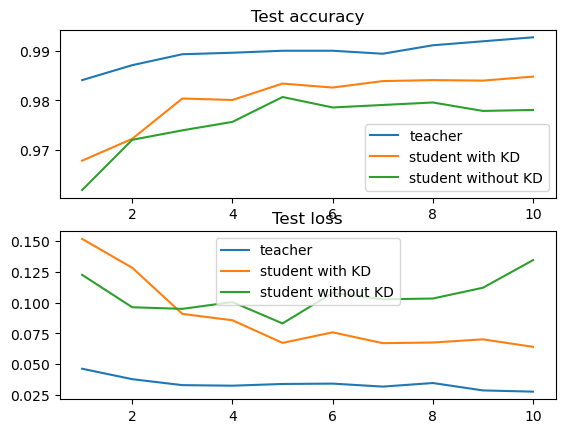

In [41]:
epochs = 10
x = list(range(1, epochs+1))

plt.subplot(2, 1, 1)
plt.plot(x, [teacher_history[i][1] for i in range(epochs)], label='teacher')
plt.plot(x, [student_kd_history[i][1] for i in range(epochs)], label='student with KD')
plt.plot(x, [student_simple_history[i][1] for i in range(epochs)], label='student without KD')

plt.title('Test accuracy')
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(x, [teacher_history[i][0] for i in range(epochs)], label='teacher')
plt.plot(x, [student_kd_history[i][0] for i in range(epochs)], label='student with KD')
plt.plot(x, [student_simple_history[i][0] for i in range(epochs)], label='student without KD')

plt.title('Test loss')
plt.legend()




In [44]:
print(student_kd_model.state_dict())

OrderedDict([('fc1.weight', tensor([[ 0.0246,  0.0440, -0.0046,  ...,  0.0468,  0.0286,  0.0269],
        [-0.0131, -0.0083, -0.0038,  ..., -0.0136,  0.0007, -0.0233],
        [ 0.0058,  0.0409, -0.0073,  ...,  0.0056,  0.0272,  0.0340],
        ...,
        [-0.0090, -0.0403, -0.0023,  ..., -0.0144, -0.0072,  0.0192],
        [ 0.0372,  0.0384,  0.0541,  ...,  0.0720,  0.0281,  0.0447],
        [ 0.0348,  0.0105,  0.0164,  ...,  0.0324,  0.0389, -0.0066]],
       device='cuda:0')), ('fc1.bias', tensor([-0.0525,  0.0017, -0.0013, -0.0124,  0.0697, -0.0133, -0.0141,  0.0482,
        -0.0081, -0.0173, -0.0208, -0.0261, -0.0113, -0.0282, -0.0024, -0.0147,
        -0.0240,  0.0192,  0.0006,  0.0004, -0.0609, -0.0152, -0.0558, -0.0329,
         0.0288, -0.0422,  0.0404, -0.0161,  0.0190, -0.0139, -0.0239, -0.0201,
        -0.0087, -0.0424,  0.0033,  0.0135, -0.0569, -0.0310, -0.0186, -0.0361,
        -0.0111, -0.0145,  0.1311, -0.0233,  0.0317,  0.0101, -0.0427, -0.0399,
        -0.0226,  0

In [47]:
print(student_simple_model.state_dict())

OrderedDict([('fc1.weight', tensor([[ 0.0242,  0.0437, -0.0049,  ...,  0.0464,  0.0282,  0.0266],
        [-0.0012,  0.0036,  0.0082,  ..., -0.0017,  0.0126, -0.0114],
        [-0.0064,  0.0287, -0.0195,  ..., -0.0066,  0.0149,  0.0218],
        ...,
        [ 0.0144, -0.0170,  0.0211,  ...,  0.0089,  0.0162,  0.0426],
        [ 0.0426,  0.0438,  0.0595,  ...,  0.0774,  0.0335,  0.0501],
        [ 0.0545,  0.0302,  0.0361,  ...,  0.0521,  0.0586,  0.0130]],
       device='cuda:0')), ('fc1.bias', tensor([-0.0679,  0.0114,  0.0060, -0.0216, -0.0022, -0.0528, -0.0025,  0.0447,
         0.0407,  0.0049, -0.0035, -0.0006, -0.0152,  0.0076,  0.0082, -0.0036,
        -0.0449,  0.0285, -0.0187, -0.0065,  0.0019, -0.0154, -0.0062,  0.0206,
         0.0226, -0.0249,  0.0160, -0.0571,  0.0398,  0.0014, -0.0715, -0.0232,
         0.0479, -0.0102,  0.0157,  0.0254, -0.0344,  0.0355, -0.0581, -0.0232,
        -0.0222,  0.0083,  0.0120, -0.0212,  0.0113, -0.0074, -0.0236, -0.0113,
        -0.0292,  0

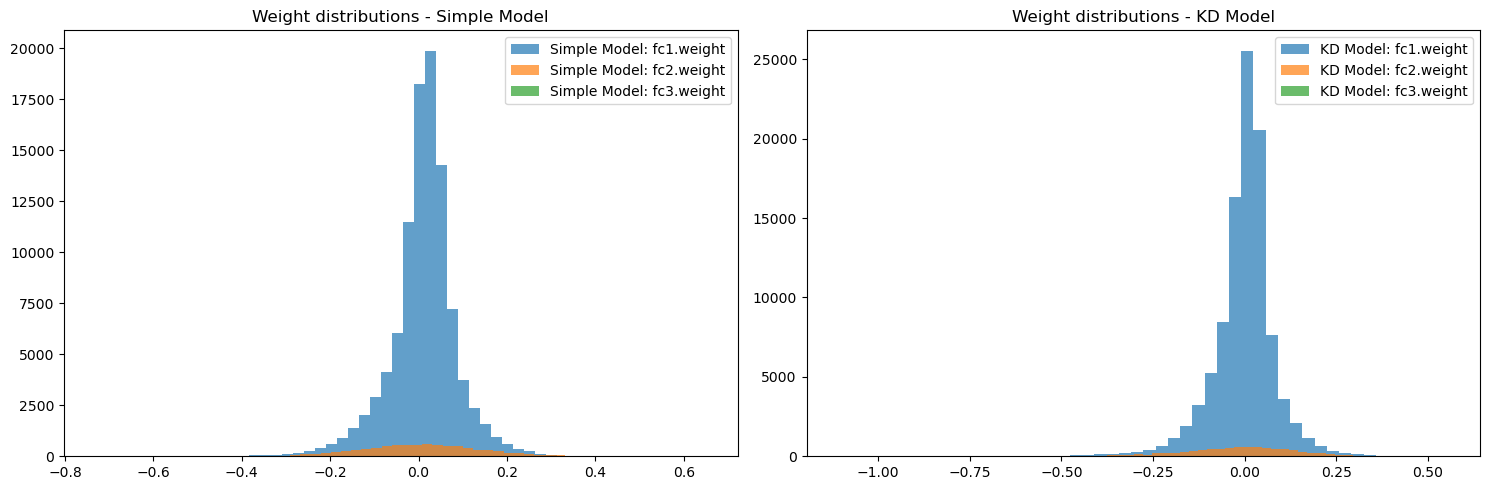

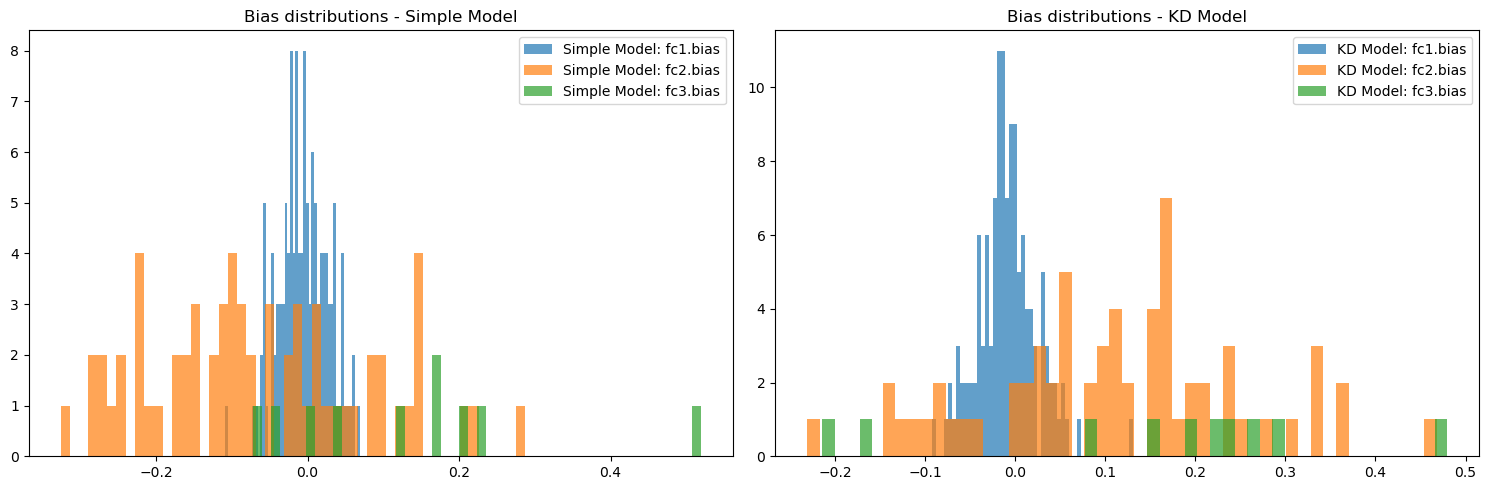

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# 获取模型参数的字典
state_dict_simple = student_simple_model.state_dict()
state_dict_kd = student_kd_model.state_dict()

# 绘制权重参数
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for name, param in state_dict_simple.items():
    if 'weight' in name:  # 只绘制权重参数
        param_cpu = param.cpu().detach().numpy().flatten()  # 将参数移动到CPU并转换为NumPy数组
        plt.hist(param_cpu, bins=50, alpha=0.7, label=f'Simple Model: {name}')
plt.title('Weight distributions - Simple Model')
plt.legend()

plt.subplot(1, 2, 2)
for name, param in state_dict_kd.items():
    if 'weight' in name:  # 只绘制权重参数
        param_cpu = param.cpu().detach().numpy().flatten()  # 将参数移动到CPU并转换为NumPy数组
        plt.hist(param_cpu, bins=50, alpha=0.7, label=f'KD Model: {name}')
plt.title('Weight distributions - KD Model')
plt.legend()

plt.tight_layout()
plt.show()

# 绘制偏置参数
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for name, param in state_dict_simple.items():
    if 'bias' in name:  # 只绘制偏置参数
        param_cpu = param.cpu().detach().numpy().flatten()  # 将参数移动到CPU并转换为NumPy数组
        plt.hist(param_cpu, bins=50, alpha=0.7, label=f'Simple Model: {name}')
plt.title('Bias distributions - Simple Model')
plt.legend()

plt.subplot(1, 2, 2)
for name, param in state_dict_kd.items():
    if 'bias' in name:  # 只绘制偏置参数
        param_cpu = param.cpu().detach().numpy().flatten()  # 将参数移动到CPU并转换为NumPy数组
        plt.hist(param_cpu, bins=50, alpha=0.7, label=f'KD Model: {name}')
plt.title('Bias distributions - KD Model')
plt.legend()

plt.tight_layout()
plt.show()
